In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
pbp_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_pbp20222023.csv"
shifts_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_shifts20222023.csv"
pbp = pd.read_csv(pbp_path)
shifts = pd.read_csv(shifts_path)

In [15]:
home_unique_teams = pbp['Home_Team'].unique()
away_unique_teams = pbp['Away_Team'].unique()
print("Home Teams:", home_unique_teams)
print("Away Teams:", away_unique_teams)

Home Teams: ['NSH' 'NYR' 'L.A' 'WSH' 'CAR' 'MTL' 'COL' 'ANA' 'EDM' 'PIT' 'PHI' 'BUF'
 'NYI' 'TOR' 'MIN' 'CGY' 'VGK' 'CBJ' 'DET' 'WPG' 'S.J' 'BOS' 'N.J' 'STL'
 'DAL' 'SEA' 'OTT' 'T.B' 'FLA' 'CHI' 'VAN' 'ARI']
Away Teams: ['S.J' 'T.B' 'VGK' 'BOS' 'CBJ' 'TOR' 'CHI' 'SEA' 'VAN' 'ARI' 'N.J' 'OTT'
 'FLA' 'WSH' 'NYR' 'DAL' 'COL' 'MTL' 'CAR' 'DET' 'ANA' 'L.A' 'NSH' 'CGY'
 'PIT' 'WPG' 'PHI' 'BUF' 'STL' 'MIN' 'NYI' 'EDM']


In [16]:
pbp['home_max_goal'] = pbp.groupby('Game_Id')['Home_Score'].transform('max')
pbp['away_max_goal'] = pbp.groupby('Game_Id')['Away_Score'].transform('max')
pbp['win'] = np.where(pbp['home_max_goal'] > pbp['away_max_goal'], 1, 0)

pbp['total_seconds_elapsed'] = ((pbp['Period'] - 1) * 1200) + pbp["Seconds_Elapsed"]
pbp["time_remaining"] = pbp["total_seconds_elapsed"].apply(lambda x: 3600 - x if x <= 3600 else -(x - 3600))

pbp['score_diff'] = pbp['Home_Score'] - pbp['Away_Score']
pbp['skater_diff'] = pbp['Home_Players'] - pbp['Away_Players']
pbp['goalie_pulled'] = np.where(pbp['Home_Players'] < 5, 1, 0)
pbp['power_play'] = np.where((pbp['Home_Players'] > pbp['Away_Players']) | (pbp['Away_Players'] > pbp['Home_Players']), 1, 0)

shifts_agg = shifts.groupby(['Game_Id', 'Player_Id'])['Duration'].sum().reset_index()
pbp = pbp.merge(shifts_agg, left_on=['Game_Id', 'p1_ID'], right_on=['Game_Id', 'Player_Id'], how='left')
pbp.rename(columns={'Duration': 'ice_time'}, inplace=True)
pbp['ice_time'] = pbp['ice_time'].fillna(0)

wp_df = pbp[['time_remaining', 'score_diff', 'skater_diff', 'goalie_pulled', 'power_play', 'ice_time', 'win']]
wp_df = wp_df.dropna()

In [17]:
X = wp_df.drop(columns=['win'])
y = wp_df['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

In [18]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.7259
ROC AUC Score: 0.8124
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     21168
           1       0.74      0.74      0.74     23263

    accuracy                           0.73     44431
   macro avg       0.73      0.73      0.73     44431
weighted avg       0.73      0.73      0.73     44431



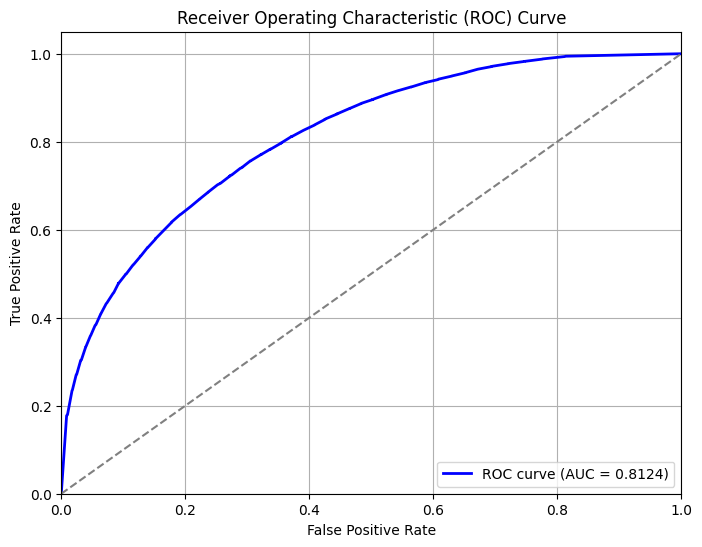

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


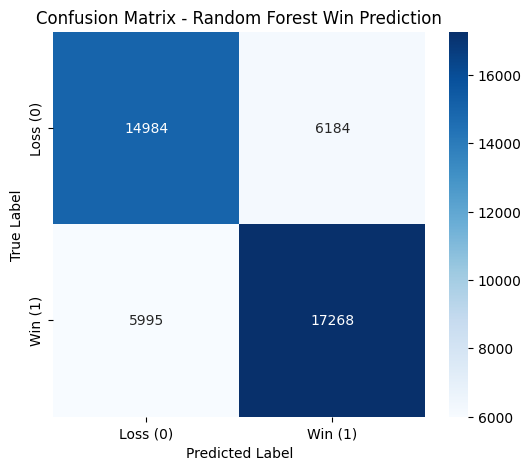

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss (0)", "Win (1)"], yticklabels=["Loss (0)", "Win (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Win Prediction")
plt.show()

In [9]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']